In [22]:
using Flux
using Flux: onehot, onecold, logitcrossentropy #, throttle, @epochs
using MLDatasets
using Random
using JLD2
using Statistics
using MLJBase
using BSON: @load # for load weights
using Plots
using Zygote
using Distributions

In [23]:
# xtrain, ytrain = MLDatasets.MNIST.traindata(Float32)
# xtest, ytest = MLDatasets.MNIST.testdata(Float32)
# xtrain = Flux.flatten(xtrain)
# xtest = Flux.flatten(xtest);

In [24]:
# train_data = [ (x, onehot(l, unique(ytrain))) for (x, l) in zip(eachcol(xtrain), ytrain)]
# test_data = [ (x, onehot(l, unique(ytest))) for (x, l) in zip(eachcol(xtest), ytest)];

In [25]:
# train_data = train_data[1:70]
# test_data = test_data[1:10];

In [26]:
# model = Chain(Dense(28*28, 32, relu), Dense(32, 10)) #define the model 

In [27]:
train_data = JLD2.load_object("data/train_data.jld2");
test_data = JLD2.load_object("data/test_data.jld2");
x_train = JLD2.load_object("data/x_train.jld2");
y_train = JLD2.load_object("data/y_train.jld2");
x_test  = JLD2.load_object("data/x_test.jld2");
y_test  = JLD2.load_object("data/y_test.jld2");

In [28]:
model = Chain(Dense(19, 2*19, sigmoid), Dense(2*19, 2)) #define the model 
θ, re = Flux.destructure(model); 
Dimension = size(θ)[1]; #number of parameters

pop = 2000 # number of food sources
tryLimit = 10 # limit of the number of tries
maxCycle = 20 # maximum number of cycles
acc = 1 # acceleration constant

lowerBound = -100
upperBound = 100

rng =Random.default_rng()

globalWeights = [Vector{Float64}(undef,Dimension) for _ in 1:pop]; 
globalFoodSourceFitness = zeros(Float64, pop)
cumProb = zeros(Float64, pop)
globalfoodSourceCount = zeros(Float64, pop)
preCal = upperBound-lowerBound;


In [29]:

function initABC()
    for i in 1:pop
        for j in 1:Dimension
            temp = lowerBound + rand()*preCal
            if temp < lowerBound
                temp = lowerBound
            elseif temp > upperBound
                temp = upperBound
            end
            globalWeights[i][j] = temp
        end
        globalFoodSourceFitness[i] = calculateFitness(globalWeights[i])
        
        globalfoodSourceCount[i] = 0
    end
    calCumFitness();
    bestWeight = globalWeights[getBest()];
end

function FindNewFoodSource(index)
    j = index
    while j == index
        j = rand(1:pop)
    end
    newSource = zeros(Float64,Dimension)
    for i in 1:Dimension
        
        temp = globalWeights[index][i] + acc*rand(Uniform(-1,1))*(globalWeights[index][i]-globalWeights[j][i])
        if temp < lowerBound
            temp = lowerBound
        elseif temp > upperBound
            temp = upperBound
        end
        newSource[i] = temp
    end
    updateFoodSource(index, newSource)
end


function updateFoodSource(index, newSource)
    localFitness = calculateFitness(newSource)
    if localFitness > globalFoodSourceFitness[index]
        globalFoodSourceFitness[index] = localFitness
        globalWeights[index] = newSource
        globalfoodSourceCount[index] = 0
    else
        globalfoodSourceCount[index] = globalfoodSourceCount[index]+1
    end
    calCumFitness();
end


loss(model) = (x,y)->Flux.logitcrossentropy(model(x), y)
loss(model,x,y) = loss(model)(x, y)
loss(xy, model) = loss(model)(hcat(map(first,xy)...), hcat(map(last,xy)...))
function calculateFitness(newWeight)
    return 1/(1+loss(train_data, re(newWeight)))
end



function checkRetire()
    for i in 1:pop
        if globalfoodSourceCount[i] > tryLimit
            if i == getBest()
                globalfoodSourceCount[i] = 0
            else
            FindNewFoodSource(i)
            end
        end
    end
end

function calCumFitness()
    fitnessSum = sum(globalFoodSourceFitness)
    fitnessProb = globalFoodSourceFitness/fitnessSum
    temp =  cumsum(fitnessProb);
    for i in 1: pop
        cumProb[i] = temp[i];
    end
end

function rouletteWheelSelection()
    randNum = rand(Uniform(0,1))
    for i in 1:pop
        if randNum <= cumProb[i]
            return i
        end
    end
end



function getBest()
    return argmax(globalFoodSourceFitness)
end


function employedBeeFindNew()
    for i in 1:pop
        FindNewFoodSource(i)
    end
end


function onlookFindNew()
    for i in 1:pop
        index = rouletteWheelSelection()
        FindNewFoodSource(index)
    end
end


function scoutBeeFindNew()
    checkRetire()
end

accuracy(model,x,y) = sum(onecold(model(x)) .== onecold(y))/size(x,2)
accuracy(xy, model) = mean( onecold(model(x)) .== onecold(y) for (x,y) in xy)

function swapBest(index,gbestWeight)
    if accuracy(train_data, re(bestWeight)) < accuracy(train_data, re(globalWeights[index]))
        return globalWeights[index];
    else
        return bestWeight;
    end
end

swapBest (generic function with 1 method)

In [30]:
save_resultTrain = zeros(maxCycle);
save_resultTest = zeros(maxCycle);
bestWeight = Vector{Float64}(undef,Dimension)
initABC()
for i in 1:maxCycle
    employedBeeFindNew()
    onlookFindNew()
    scoutBeeFindNew()
    # bestIndex = getBest()
    bestWeight = swapBest(getBest(), bestWeight);    #print("Cycle: ", i, "Best Fitness: ", globalFoodSourceFitness[bestIndex])
    save_resultTest[i] = save_resultTest[i] + accuracy(test_data, re(bestWeight))
    save_resultTrain[i] = save_resultTrain[i] + accuracy(train_data, re(bestWeight))
    #print("\n")
end

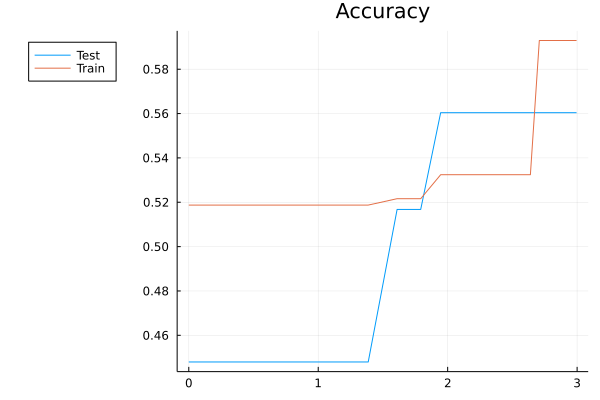

In [31]:
plot(log.(1:maxCycle), save_resultTest,label="Test")
plot!(log.(1:maxCycle), save_resultTrain,label = "Train", title = "Accuracy", legend = :outertopleft)